<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [276]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [277]:
import gc
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utilities import *
from itertools import combinations
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from surprise import accuracy, Dataset, KNNBaseline, Reader
from surprise.model_selection import cross_validate, train_test_split

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [278]:
ratings = load_data()
ratings.drop('timestamp', axis=1, inplace=True)

# Section 3
## Q1

In [279]:
n = len(ratings.movieId.unique())
m = len(ratings.userId.unique())
sparcity = np.divide(ratings.shape[0], n*m)
display(sparcity)

0.016439141608663475

## Q2

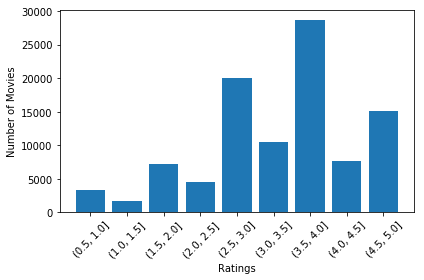

In [13]:
ratings['rating_bin'] = pd.cut(ratings['rating'], bins=np.arange(0.5, 5.5, 0.5))
bar_height = ratings.groupby(['rating_bin']).agg({'rating': 'count'})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height['rating'])
ax.set_xticks(np.arange(bar_height.shape[0]))
ax.set_xticklabels(bar_height.index,rotation=45)
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of Movies')

fig.tight_layout()
fig.savefig('report/figures/q2.png', dpi=300)

## Q3

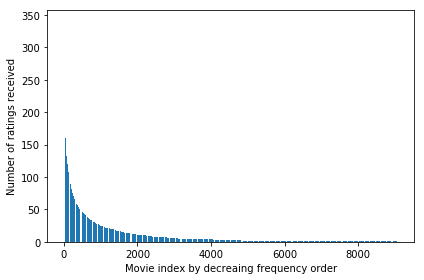

In [6]:
bar_height = ratings.groupby(['movieId']).agg({'rating': 'count'}).\
    rename(columns={'rating': 'rating_count'}).sort_values('rating_count', ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height.rating_count)
ax.set_xlabel('Movie index by decreaing frequency order')
ax.set_ylabel('Number of ratings received')

fig.tight_layout()
fig.savefig('report/figures/q3.png' dpi=300)

## Q4

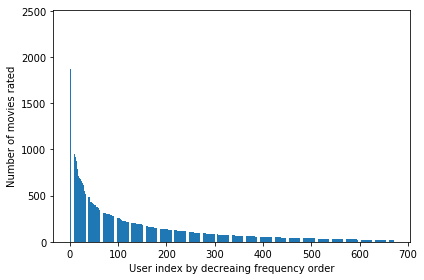

In [ ]:
bar_height = ratings.groupby('userId').agg({'rating': 'count'}).\
    rename(columns={'rating': 'rating_count'}).sort_values('rating_count', ascending=False)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height.rating_count)
ax.set_xlabel('User index by decreaing frequency order')
ax.set_ylabel('Number of movies rated')

fig.tight_layout()
fig.savefig('report/figures/q4.png', dpi=300)

## Q6

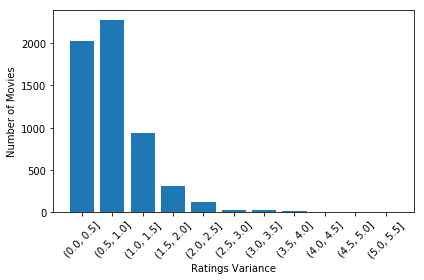

In [87]:
movie_var = ratings.groupby('movieId').agg({'rating': lambda x: np.var(x)}).rename(columns={'rating': 'rating_var'})
movie_var['rating_var_bin'] = pd.cut(movie_var.rating_var, bins=np.arange(0, movie_var.rating_var.max()+0.5, 0.5))
bar_height = movie_var.groupby('rating_var_bin').agg({'rating_var': 'count'}).rename(columns={'rating_var': 'count'})

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(np.arange(bar_height.shape[0]), bar_height['count'])
ax.set_xticks(np.arange(bar_height.shape[0]))
ax.set_xticklabels(bar_height.index,rotation=45)
ax.set_xlabel('Ratings Variance')
ax.set_ylabel('Number of Movies')

fig.tight_layout()
fig.savefig('report/figures/q6.png', dpi=300)

# Section 4


## Q7 - Q9

$u_u = \frac{1}{n}\sum_{k \in I_u} r_{uk}$

Movies that have been both rated by user $u$ and user $v$. It could be an empty set.

## Q10

In [265]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
sim_options = {'name': 'pearson'}

mae_errors = []
rmse_error = []
ks = np.arange(2, 102, 2)

for k in ks:
    if k % 20 == 0:
        print(k)
    algo = KNNBaseline(k=k, sim_options=sim_options)
    results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    mae_errors.append(results['test_mae'].mean())
    rmse_error.append(results['test_rmse'].mean())

20
40
60
80
100


In [266]:
min_k = np.max([np.argmax(mae_errors - np.min(mae_errors) <= 5e-3), np.argmax(rmse_error - np.min(rmse_error) <= 5e-3)])
ks[min_k]

18

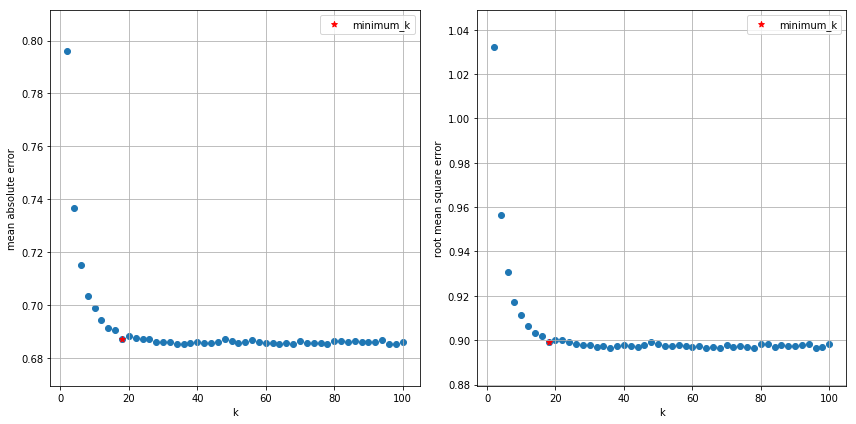

In [267]:
plot_mae_n_rmse(mae_errors, rmse_error, ks, min_k, 'q10.png')

## Q11

In [268]:
display(min_k)
display(rmse_error[min_k])
display(mae_errors[min_k])

8

0.8991342805734897

0.6873130863250546

## Q12 - Q14

In [88]:
movie_rating_freq = ratings.groupby('movieId').agg({'userId': 'count'}).rename(columns={'userId': 'rating_count'})
movie_var = ratings.groupby('movieId').agg({'rating': lambda x: np.var(x)}).rename(columns={'rating': 'rating_var'})
popular_movies = movie_rating_freq[movie_rating_freq.rating_count > 2].index
unpplar_movies = movie_rating_freq[movie_rating_freq.rating_count < 3].index
highvar_movies = movie_rating_freq[np.logical_and(movie_rating_freq.rating_count > 5, movie_var.rating_var > 2)].index

In [89]:
sim_options = {'name': 'pearson'}
reader = Reader(rating_scale=(1, 5))
popular_mae_errors = []
unpplar_mae_errors = []
highvar_mae_errors = []
popular_rmse_error = []
unpplar_rmse_error = []
highvar_rmse_error = []

ks = np.arange(2, 102, 2)

for k in ks:
    print(k)
    popular_mae_folds = []
    unpplar_mae_folds = []
    highvar_mae_folds = []
    popular_rmse_fold = []
    unpplar_rmse_fold = []
    highvar_rmse_fold = []
    
    algo = KNNBaseline(k=k, sim_options=sim_options)
    kfold = KFold(n_splits=10, shuffle=True, random_state=177)
    for trn_idx, tst_idx in kfold.split(ratings):
        trn = ratings.iloc[trn_idx, :]
        tst = ratings.iloc[tst_idx, :]
        popular_tst = tst[tst.movieId.isin(popular_movies)]
        unpplar_tst = tst[tst.movieId.isin(unpplar_movies)]
        highvar_tst = tst[tst.movieId.isin(highvar_movies)]
        
        trn_suprise = Dataset.load_from_df(trn[['userId', 'movieId', 'rating']], reader).build_full_trainset()
        popular_tst = Dataset.load_from_df(popular_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        unpplar_tst = Dataset.load_from_df(unpplar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        highvar_tst = Dataset.load_from_df(highvar_tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()
        
        algo.fit(trn_suprise)
        popular_results = algo.test(popular_tst, verbose=False)
        unpplar_results = algo.test(unpplar_tst, verbose=False)
        highvar_results = algo.test(highvar_tst, verbose=False)
        
        popular_mae_folds.append(accuracy.mae(popular_results, verbose=False))
        unpplar_mae_folds.append(accuracy.mae(unpplar_results, verbose=False))
        highvar_mae_folds.append(accuracy.mae(highvar_results, verbose=False))
        
        popular_rmse_fold.append(accuracy.rmse(popular_results, verbose=False))
        unpplar_rmse_fold.append(accuracy.rmse(unpplar_results, verbose=False))
        highvar_rmse_fold.append(accuracy.rmse(highvar_results, verbose=False))
    
    popular_mae_errors.append(np.mean(popular_mae_folds))
    unpplar_mae_errors.append(np.mean(unpplar_mae_folds))
    highvar_mae_errors.append(np.mean(highvar_mae_folds))
    popular_rmse_error.append(np.mean(popular_rmse_fold))
    unpplar_rmse_error.append(np.mean(unpplar_rmse_fold))
    highvar_rmse_error.append(np.mean(highvar_rmse_fold))

2
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using al

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
18
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
34
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
48
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
64
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
78
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
94
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity

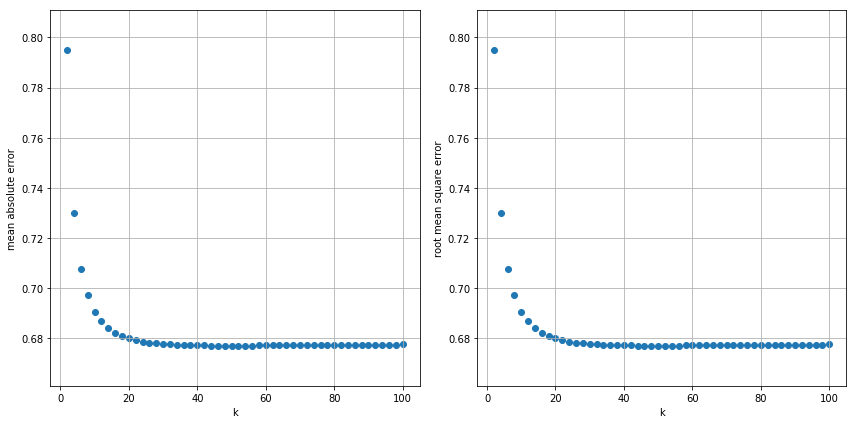

In [90]:
plot_mae_n_rmse(popular_mae_errors, popular_mae_errors, ks, None, 'q12.png')

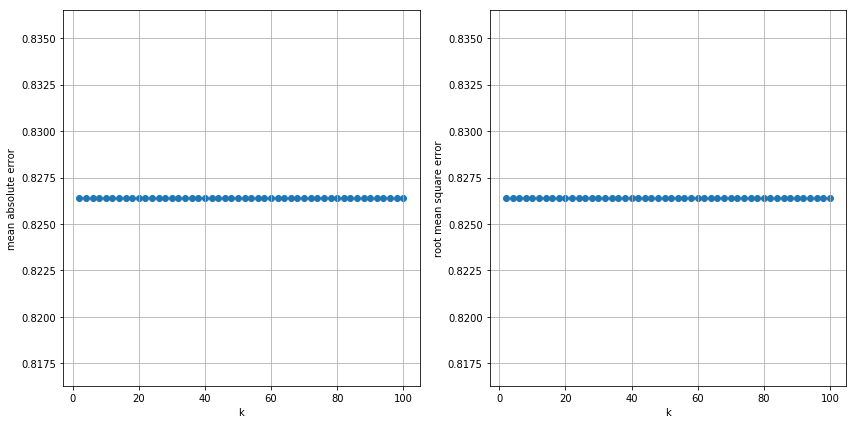

In [91]:
plot_mae_n_rmse(unpplar_mae_errors, unpplar_mae_errors, ks, None, 'q13.png')

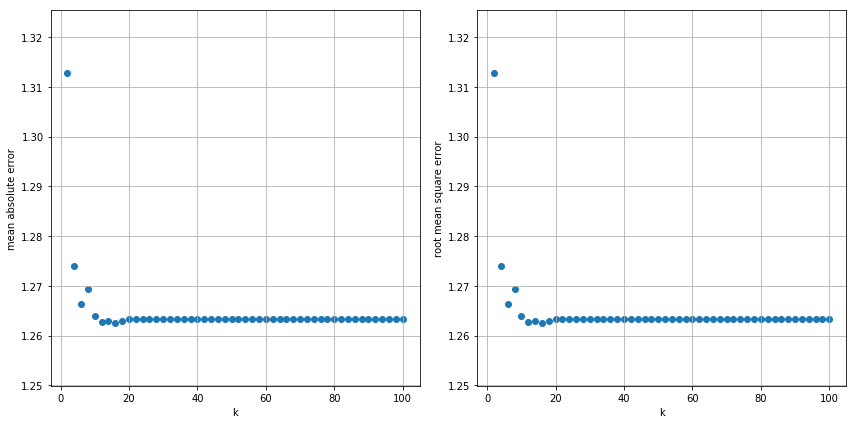

In [92]:
plot_mae_n_rmse(highvar_mae_errors, highvar_mae_errors, ks, None, 'q14.png')

## Q15

In [280]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings, reader)
sim_options = {'name': 'pearson'}
algo = KNNBaseline(k=18, sim_options=sim_options)

trn, tst = train_test_split(data, test_size=0.1)
algo.fit(trn)
prediction = algo.test(tst, verbose=False)
y_true_pred = np.array([pred[2:4] for pred in prediction])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


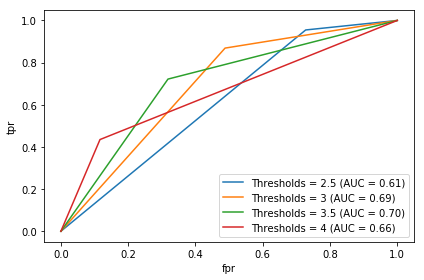

In [281]:
fig = plt.figure()
ax = fig.add_subplot(111)
thresholds = [2.5, 3, 3.5, 4]

for threshold in thresholds:
    results = np.where(y_true_pred>=threshold, 1, 0)
    fpr, tpr, thresholds = roc_curve(results[:, 0], results[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label='Thresholds = %s (AUC = %0.2f)' % (threshold, roc_auc))
    ax.set_xlabel('fpr')
    ax.set_ylabel('tpr')
    ax.legend()
    
fig.tight_layout()
fig.savefig('report/figures/q15.png', dpi=300)

In [ ]:
# save for q34

In [238]:
results = np.where(y_true_pred>3, 1, 0)
pickle.dump(results, open('results/' + 'q34-knn', 'wb'))

# Section 5.2

## Q16 - Q23

# Section 5.3

## Q24 - Q 29

# Section 6

## Q30 - Q33

# Section 7

## Q34

# Section 8

## Q35

## Q36

In [312]:
n_splits = 10
threshold = 3
ts = np.arange(1, 26, 1).tolist()
scoring = np.zeros([n_splits, len(ts)*2])
args = ts + [threshold]

reader = Reader(rating_scale=(1, 5))
sim_options = {'name': 'pearson'}
algo = KNNBaseline(k=18, sim_options=sim_options)
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=177)

for i, (trn_idx, tst_idx) in enumerate(kfold.split(ratings)):
    trn = ratings.iloc[trn_idx, :]
    tst = ratings.iloc[tst_idx, :]
    
    trn_surprise = Dataset.load_from_df(trn[['userId', 'movieId', 'rating']], reader).build_full_trainset()
    tst_surprise = Dataset.load_from_df(tst[['userId', 'movieId', 'rating']], reader).build_full_trainset().build_testset()

    algo.fit(trn_surprise)
    prediction = algo.test(tst_surprise, verbose=False)
    
    grouped_tst = build_tst(tst, prediction)
    results = grouped_tst.apply(compute_ppv_tpr, *args)
    
    scoring_folds = []
    for j in range(50):
        scoring_folds.append(results.apply(lambda x: x[j]).mean(skipna=True))
    scoring[i, :] = scoring_folds
scoring = scoring.mean(axis=0).reshape(2, len(ts))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

In [313]:
pickle.dump(results, open('results/' + 'q36-knn', 'wb'))

## Q37

## Q38

## Q39